In [2]:
import numpy as np
import cv2 
import re
from PIL import Image
import pandas as pd
import os
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

from model import MobileFaceNet
device = torch.device('cuda:0')

MODEL_WEIGHTS = os.path.join("../model_mobilefacenet.pth")
EMBEDDING_SIZE = 512
VGG_PATH = '../../../data/train_aligned'
TWINS_PATH = '../../../data/twins_aligned_dlib'

### Load model

In [4]:
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-3])
        self.pool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return x.view(x.size(0), -1)

base_model = MobileFaceNet(embedding_size=EMBEDDING_SIZE)

checkpoint = torch.load(MODEL_WEIGHTS, map_location=device)
base_model.load_state_dict(checkpoint)
feature_extractor = ModelBottom(base_model).to(device)

In [5]:
# check
feature_extractor(torch.zeros(1,3,254,484).to(device)).shape

torch.Size([1, 512])

### Normalize data

In [6]:
from torchvision.transforms import Compose, ToTensor, Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = Compose([ToTensor(),
                     Normalize(mean, std)])

In [7]:
def parse_keypoints(keypoints_raw):
    keypoints = []
    for kp_raw in keypoints_raw.split('\n'):
        kp = re.findall(r'\d+', kp_raw)
        assert len(kp)==2
        keypoints.append(list(map(int, kp)))
    return np.array(keypoints)

def get_bbox(keypoints):
    min_x, min_y = keypoints.min(axis=0)
    max_x, max_y = keypoints.max(axis=0)
    
    return [int(x) for x in [min_x, min_y, max_x, max_y]]

def get_croped_img(path, person_id, img_id, df, transform = None, pad_ratio = 0.4, resize=None):
#     df = pd.read_csv(os.path.join(TWINS_PATH, person_id, 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
    img = cv2.imread(os.path.join(path, person_id, img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    kp = parse_keypoints(df[df.img_id == img_id]['4'].values[0])
    
    if resize:
        img = cv2.resize(img, (0,0), fx=resize, fy=resize)
        kp=kp*resize
#         print(kp)
    min_x, min_y, max_x, max_y = get_bbox(kp)
    pad_x = int(pad_ratio*(max_x-min_x))
    pad_y = int(pad_ratio*(max_y-min_y))
#     print(min_x, min_y, max_x, max_y, pad_x, pad_y)
    
    img = img[max(0, min_y-pad_y):min(max_y+pad_y, img.shape[0]), \
               max(0, min_x-pad_x):min(max_x+pad_x, img.shape[1]), :]
    if transform:
        img =  transform(img)
    return img

def get_embeddings(path, person_id, cnn, transform=transform, pad_ratio=0.15, resize=0.15, \
                   front=False, features_dim=EMBEDDING_SIZE):
    df = pd.read_csv(os.path.join(path, person_id, 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
    if front:
        df = df[(df['1']=='front')]
    images = df.img_id.values
    embeddings = np.zeros((len(images), features_dim))
    for i, img_id in tqdm(enumerate(images), total = len(images)):
        img = get_croped_img(path, person_id, img_id, df, transform=transform,\
                             pad_ratio=pad_ratio, resize=resize)
        with torch.no_grad():
            img = img[None, :].to(device)
            features = cnn(img)
            embeddings[i,:] = features.detach().cpu().numpy()
    return embeddings
    

### Process twins

In [ ]:
twins_ids = os.listdir(TWINS_PATH)
for person_id in tqdm(twins_ids):
    embeddings = get_embeddings(TWINS_PATH, person_id, cnn=feature_extractor)
    np.save(os.path.join(TWINS_PATH, person_id, 'mobile_net'), embeddings)

### Set up dataset

In [8]:
df_meta = pd.read_csv('../../../data/twins_meta/image-metadata-2.0.csv').drop(columns = ['Unnamed: 9'])
df_rel = pd.read_csv('../../../data/twins_meta/twins-relationship-info.csv', index_col=0)

columns = df_meta.columns
df_meta = df_meta.rename(columns=dict([(column, column.strip(' ')) for column in columns]))
df_meta = df_meta[(df_meta.yaw==0)&(df_meta.expression!=' Happiness')&(df_meta.glasses==' none')]
df_meta['person_id'] = df_meta.filename.apply(lambda x: x.split('d')[0])
df_meta['filename'] = df_meta.filename.apply(lambda x: x.replace('nef', 'jpg'))
df_meta.head()

,filename,date,gender,race,yearofbirth,weather,glasses,expression,yaw,person_id
16,90003d17.jpg,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003
17,90003d18.jpg,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003
36,90003d40.jpg,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003
38,90003d42.jpg,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Inside,none,BlankStare,0,90003
56,90003d60.jpg,2009-08-08 00:00:00,Male,Black-or-African-American,1970,Rain,none,BlankStare,0,90003


In [9]:
df_rel.subject_id1 = df_rel.subject_id1.apply(lambda x: x.split('S')[1])
df_rel.subject_id2 = df_rel.subject_id2.apply(lambda x: x.split('S')[1])
exists = df_rel.subject_id1.apply(lambda x: os.path.exists(os.path.join(TWINS_PATH, x)))
df_rel = df_rel[exists]
df_rel.head()

,subject_id1,subject_id2,relationship_type
1,90004,90005,Fraternal
2,90005,90004,Fraternal
3,90006,90007,Fraternal
4,90007,90006,Fraternal
5,90008,90009,Identical


In [10]:
FACIAL_LANDMARKS_68_IDXS = dict(
    [("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))]
)

def flip_keypoints(kp, img_width):
    flipped_kp = kp.copy()
    for key, (low, high) in FACIAL_LANDMARKS_68_IDXS.items():
        for i in range((high-low)): 
            # flip order
            flipped_kp[low+i] = kp[high-1-i]
            # flip location
            flipped_kp[low+i, 0] = img.shape[1]-flipped_kp[low+i, 0]
    return flipped_kp

def get_features(path, person_id, img_id, features_file='mobile_net.npy', flipped=False):
    df = pd.read_csv(os.path.join(path, person_id, 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
    features = np.load(os.path.join(path, person_id, features_file))[df[df.img_id==img_id].index.values]
    kp = parse_keypoints(df[df.img_id == img_id]['4'].values[0])
    if flipped:
        kp = flip_keypoints(kp, img.shape[1])
#     print(features.shape)
    min_x, min_y, max_x, max_y = get_bbox(kp)
    delta_x = max_x-min_x
    delta_y = max_y-min_y
    kp = (kp - np.array([min_x, min_y]))/np.array([delta_x, delta_y])
    vector = np.concatenate([kp.flatten(), features.squeeze()])
    return kp.flatten()

### Visualize to check crops

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 230, 230])


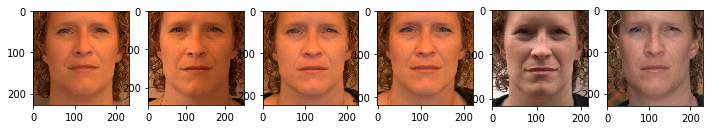

In [44]:
person_id = os.listdir(TWINS_PATH)[11]
df = pd.read_csv(os.path.join(TWINS_PATH, person_id, 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
images = df.img_id.values
n=len(images)
fig, axs = plt.subplots(1, n, figsize=(12,12))

for i in range(n):
    img = get_croped_img(TWINS_PATH, person_id, images[i], df, transform=transform, pad_ratio = 0.15, resize=0.15)
    
    axs[i].imshow(img.numpy().transpose(1, 2, 0)*std+mean)
print(img.shape)

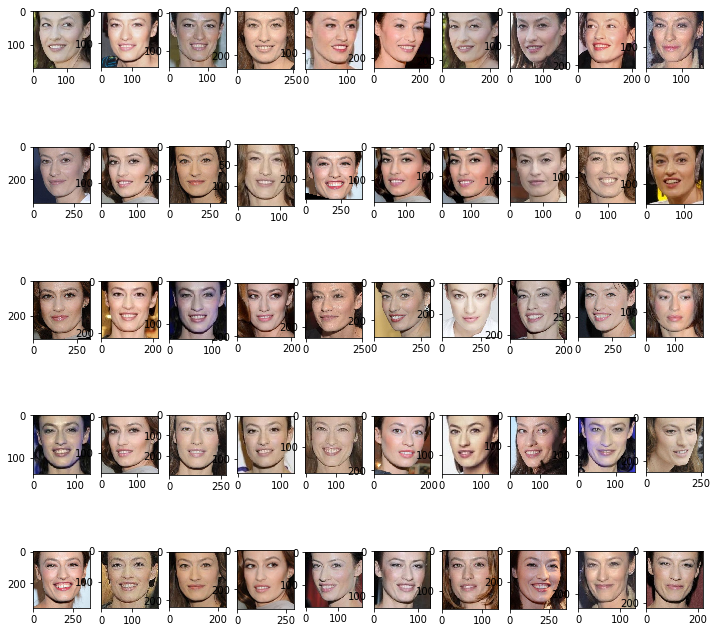

In [43]:
person_id = 'n005419'
df = pd.read_csv(os.path.join(VGG_PATH, person_id, 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
image_list = df.iloc[:50].img_id.values#[(df['1']=='front')].img_id.values

n_cols = 10
n_rows = len(image_list)//n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,12))

for i in range(n_rows):
    for j in range(n_cols):
        img = get_croped_img(VGG_PATH, person_id, image_list[j*n_rows+i], df, pad_ratio = 0.15)
        axs[i,j].imshow(img)

In [11]:
# group all relevant images for each id
data = df_meta.groupby('person_id').filename.apply(list).to_frame()
data['person_id'] = data.index
data = data.reset_index(drop=True)
data['pairs'] = data.filename.apply(lambda x: np.random.choice(x, size=2, replace=False) if len(x)>=2 else None)
data.index = data.person_id
data.head()

,filename,person_id,pairs
person_id,,,
90003,"[90003d17.jpg, 90003d18.jpg, 90003d40.jpg, 900...",90003,"[90003d61.jpg, 90003d40.jpg]"
90004,"[90004d17.jpg, 90004d18.jpg, 90004d40.jpg, 900...",90004,"[90004d42.jpg, 90004d18.jpg]"
90005,"[90005d17.jpg, 90005d18.jpg, 90005d40.jpg, 900...",90005,"[90005d60.jpg, 90005d40.jpg]"
90006,"[90006d14.jpg, 90006d15.jpg, 90006d37.jpg, 900...",90006,"[90006d37.jpg, 90006d58.jpg]"
90007,"[90007d17.jpg, 90007d18.jpg, 90007d36.jpg, 900...",90007,"[90007d55.jpg, 90007d18.jpg]"


### Lgb + svm

In [21]:
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [14]:
NUM_FEATURES = 68*2
same = np.zeros((data.shape[0], NUM_FEATURES))
data_same = data[~data['pairs'].isnull()]
for i, (person_id, img_ids) in tqdm(enumerate(data_same[['person_id', 'pairs']].values), total=data_same.shape[0]):
    features1 = get_features(TWINS_PATH, person_id, img_ids[0])
    features2 = get_features(TWINS_PATH, person_id, img_ids[1])
    same[i] = features1-features2# np.concatenate([features1, features2])

In [15]:
same_flipped = np.zeros((data.shape[0], NUM_FEATURES))
data_same_flipped = data[~data['pairs'].isnull()]
for i, (person_id, img_ids) in tqdm(enumerate(data_same_flipped[['person_id', 'pairs']].values),\
                                    total=data_same_flipped.shape[0]):
    features1 = get_features(TWINS_PATH, person_id, img_ids[0])
    features2 = get_features(TWINS_PATH, person_id, img_ids[1])
    same_flipped[i] = features1-features2# np.concatenate([features1, features2])

In [16]:
different = np.zeros((df_rel.shape[0], NUM_FEATURES))
for i, (person_id1, person_id2) in tqdm(enumerate(df_rel[['subject_id1','subject_id2']].values), total=df_rel.shape[0]):
    
    img_id1 = np.random.choice(data.loc[person_id1].filename, 1)[0]
    img_id2 = np.random.choice(data.loc[person_id2].filename, 1)[0]
    features1 = get_features(TWINS_PATH, person_id1, img_id1)
    features2 = get_features(TWINS_PATH, person_id2, img_id2)
    different[i] =features1-features2# np.concatenate([features1, features2])   

In [17]:
idx_same = np.random.choice(same.shape[0], size=210, replace=False)
idx_flipped = np.random.choice(same_flipped.shape[0], size=210, replace=False)

In [18]:
# X = np.concatenate([same[idx_same], same_flipped[idx_flipped], different], axis=0)
# y = np.concatenate([np.ones(len(idx_same)), np.zeros(len(idx_flipped)), np.zeros(different.shape[0])])
X = np.concatenate([same, different], axis=0)
y = np.concatenate([np.ones(same.shape[0]), np.zeros(different.shape[0])])
X.shape, y.shape

((857, 136), (857,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
svc = SVC(kernel='linear', C=10, probability=True)
svc.fit(X_train, y_train)
preds = svc.predict_proba(X_test)
roc_auc_score(y_test, preds[:,1])

0.6079326923076923

In [32]:
model = lgb.LGBMClassifier(max_depth=6, learning_rate=0.01)

In [33]:
model.fit(X_train, y_train, eval_set = (X_test, y_test), eval_metric='auc')

[1]	valid_0's binary_logloss: 0.692591	valid_0's auc: 0.604627
[2]	valid_0's binary_logloss: 0.691795	valid_0's auc: 0.633924
[3]	valid_0's binary_logloss: 0.69115	valid_0's auc: 0.638882
[4]	valid_0's binary_logloss: 0.690402	valid_0's auc: 0.640264
[5]	valid_0's binary_logloss: 0.689827	valid_0's auc: 0.641106
[6]	valid_0's binary_logloss: 0.689429	valid_0's auc: 0.63122
[7]	valid_0's binary_logloss: 0.688866	valid_0's auc: 0.627885
[8]	valid_0's binary_logloss: 0.68834	valid_0's auc: 0.627374
[9]	valid_0's binary_logloss: 0.68782	valid_0's auc: 0.623618
[10]	valid_0's binary_logloss: 0.687237	valid_0's auc: 0.621544
[11]	valid_0's binary_logloss: 0.686673	valid_0's auc: 0.622506
[12]	valid_0's binary_logloss: 0.686224	valid_0's auc: 0.619381
[13]	valid_0's binary_logloss: 0.685829	valid_0's auc: 0.622656
[14]	valid_0's binary_logloss: 0.685573	valid_0's auc: 0.621514
[15]	valid_0's binary_logloss: 0.685468	valid_0's auc: 0.61872
[16]	valid_0's binary_logloss: 0.684957	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=6,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)